Idea: There are certainly many different ways, with as many parameters as I have, to get differrent D values. I want to find severl different "tracks" i.e., pull different levers of the input into the generation of the branch networks to get the same d values. The motivation behind this is that we want to mitigate against humans and computer vision models being trained to understand and distinguish fractal dimension don't focus too much on any one parameter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from tqdm.auto import tqdm

from FF.fractal_generation import branching_network as bn   
from fracstack import measure_dimension, portfolio_plot

In [2]:
def latin_hypercube_sampling(param_bounds, n_samples):
    """
    Latin Hypercube Sampling that guarantees inclusion of parameter bounds.
    
    param_bounds: List of (low, high) for each parameter dimension
    n_samples: Number of sample points to create (must be > 2)
    
    Returns: Array of shape (n_samples, d) where d is number of parameters
    """
    if n_samples < 3:
        raise ValueError("n_samples must be at least 3 to include endpoints and middle points")
        
    d = len(param_bounds)
    samples = np.empty((n_samples, d), dtype=float)
    
    for i, (low, high) in enumerate(param_bounds):
        # Create n_samples-2 points using LHS (excluding endpoints)
        bins = np.linspace(0, 1, n_samples - 1)  # n_samples - 1 points to create n_samples - 2 bins
        
        # Get the lower edge of each bin
        bin_starts = bins[:-1]
        # Get the bin width
        bin_width = 1.0 / (n_samples - 2)
        
        # Generate random offsets within each bin
        random_offsets = np.random.rand(n_samples - 2) * bin_width
        
        # Final positions = bin_start + random_offset
        positions = bin_starts + random_offsets
        
        # Randomly permute these positions
        positions = np.random.permutation(positions)
        
        # Add endpoints (0 and 1)
        positions = np.concatenate(([0], positions, [1]))
        
        # Map from [0,1] to [low,high]
        samples[:, i] = low + positions * (high - low)
    
    return samples


def generate_parameter_dataset(n_samples=1000, plot = False):
    """
    Generate a dataset covering the parameter space using Latin Hypercube Sampling.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    
    Returns:
    --------
    DataFrame with parameter combinations
    """
    # Define parameter bounds (min, max) for each parameter
    param_bounds = {
        'depth': (3, 11),
        'mean_soma_radius': (1, 1),  # Single value converted to range
        'std_soma_radius': (1, 1),   # Single value converted to range
        'D': (1.0, 2.0),
        'mean_branches': (0.75, 1.35),
        'randomness': (0.1, 0.1),    # Single value converted to range
        'curviness_magnitude': (1, 1),  # Single value converted to range
        'n_primary_dendrites': (2, 6),
        'initial_thickness': (5, 5),  # Single value converted to range
        'total_length': (100, 1000),
        'branch_angle': (np.pi/3, np.pi/3),  # Single value converted to range
        'num_neurons': (3, 30),
        'edge_margin': (100, 100)    # Single value converted to range
    }
    
    # Convert bounds to list format for latin_hypercube_sampling
    bounds_list = [(low, high) for low, high in param_bounds.values()]
    
    # Generate samples
    samples = latin_hypercube_sampling(bounds_list, n_samples)
    
    # Convert to DataFrame
    df = pd.DataFrame(samples, columns=param_bounds.keys())
    
    # Round integer parameters
    integer_params = ['depth', 'n_primary_dendrites', 'num_neurons']
    for param in integer_params:
        df[param] = df[param].round().astype(int)
    
    # Add constant parameters
    df['width'] = 2048
    df['height'] = 2048
    df['weave_type'] = 'Gauss'
    df['curviness'] = 'Gauss'

    if plot:
        # Plot histograms of parameter distributions
        params_to_plot = [col for col in df.columns if col not in ['width', 'height', 'weave_type', 'curviness']]
        n_cols = 3
        n_rows = (len(params_to_plot) + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 4*n_rows))
        for i, param in enumerate(params_to_plot, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.histplot(df[param], bins=30)
            plt.title(param)
            plt.xlabel('')
        plt.tight_layout()
        plt.show()
    
    return df


def generate_single_sample(params):
    """
    Generate and measure a single network sample.
    This function will be run in parallel.
    """
    idx, param_values = params
    
    # Create parameter dictionaries from param_values
    neuron_params = {
        'depth': param_values['depth'],
        'mean_soma_radius': param_values['mean_soma_radius'],
        'std_soma_radius': param_values['std_soma_radius'],
        'D': param_values['D'],
        'branch_angle': param_values['branch_angle'],
        'mean_branches': param_values['mean_branches'],
        'weave_type': param_values['weave_type'],
        'randomness': param_values['randomness'],
        'curviness': param_values['curviness'],
        'curviness_magnitude': param_values['curviness_magnitude'],
        'n_primary_dendrites': param_values['n_primary_dendrites'],
        'initial_thickness': param_values['initial_thickness'],
        'total_length': param_values['total_length']
    }
    
    network_params = {
        'width': param_values['width'],
        'height': param_values['height'],
        'num_neurons': param_values['num_neurons'],
        'edge_margin': param_values['edge_margin']
    }

    # Generate network
    net = bn.generate_network(
        network_id=f'net_{idx}',
        neuron_params=neuron_params,
        network_params=network_params
    )
    
    # Measure dimensions
    D0_result = measure_dimension(net.outline_mask, mode='D0', 
                                min_size=16, max_size=506, 
                                num_sizes=50, num_pos=20, 
                                multiprocessing=False)  # Set to False for parallel workers
    
    D1_result = measure_dimension(net.outline_mask, mode='D1', 
                                min_size=16, max_size=506, 
                                num_sizes=50, num_pos=20, 
                                multiprocessing=False)
    
    # Add dimension measurements to parameter values
    param_values['D0'] = D0_result['D']
    param_values['D1'] = D1_result['D']
    param_values['R2_D0'] = D0_result['R2']
    param_values['R2_D1'] = D1_result['R2']
    
    return param_values


def generate_and_measure_networks_parallel(n_samples=1000, num_workers=None):
    """
    Generate branching networks using Latin Hypercube sampling of parameters,
    measure their fractal dimensions in parallel, and return all results.
    """
    if num_workers is None:
        num_workers = mp.cpu_count()
    print(f"Using {num_workers} workers")
    
    # Generate parameter samples
    param_df = generate_parameter_dataset(n_samples)
    
    # Create list of (idx, params) tuples for parallel processing
    tasks = [(idx, param_df.iloc[idx].to_dict()) for idx in range(len(param_df))]
    
    # Create multiprocessing pool and run tasks
    with mp.Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(generate_single_sample, tasks), 
                          total=n_samples, 
                          desc="Generating samples"))
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    print(f"\nGenerated {len(results_df)} samples")
    print("\nSummary of measurements:")
    print(results_df[['D0', 'D1', 'R2_D0', 'R2_D1']].describe())
    
    # Save results
    results_df.to_csv('parameter_samples_parallel.csv', index=False)
    
    return results_df


def generate_and_measure_networks(n_samples=1000):
    """
    Generate branching networks using Latin Hypercube sampling of parameters,
    measure their fractal dimensions, and return all results.
    """
    # Generate parameter samples using generate_parameter_dataset
    param_df = generate_parameter_dataset(n_samples)
    
    # Add columns for dimension measurements
    param_df['D0'] = np.nan
    param_df['D1'] = np.nan
    param_df['R2_D0'] = np.nan
    param_df['R2_D1'] = np.nan
    
    for idx in range(len(param_df)):
        # Extract parameters for this sample
        neuron_params = {
            'depth': param_df.loc[idx, 'depth'],
            'mean_soma_radius': param_df.loc[idx, 'mean_soma_radius'],
            'std_soma_radius': param_df.loc[idx, 'std_soma_radius'],
            'D': param_df.loc[idx, 'D'],
            'branch_angle': param_df.loc[idx, 'branch_angle'],
            'mean_branches': param_df.loc[idx, 'mean_branches'],
            'weave_type': param_df.loc[idx, 'weave_type'],
            'randomness': param_df.loc[idx, 'randomness'],
            'curviness': param_df.loc[idx, 'curviness'],
            'curviness_magnitude': param_df.loc[idx, 'curviness_magnitude'],
            'n_primary_dendrites': param_df.loc[idx, 'n_primary_dendrites'],
            'initial_thickness': param_df.loc[idx, 'initial_thickness'],
            'total_length': param_df.loc[idx, 'total_length']
        }
        
        network_params = {
            'width': param_df.loc[idx, 'width'],
            'height': param_df.loc[idx, 'height'],
            'num_neurons': param_df.loc[idx, 'num_neurons'],
            'edge_margin': param_df.loc[idx, 'edge_margin']
        }

        min_size = 16
        max_size = 506
        num_sizes = 50
        num_pos = 100
        multiprocessing = True

        # Generate network
        net = bn.generate_network(
            network_id=f'net_{idx}',
            neuron_params=neuron_params,
            network_params=network_params
        )
        
        # Measure dimensions
        D0_result_dict = measure_dimension(net.outline_mask, mode='D0', min_size=min_size, max_size=max_size, 
                                   num_sizes=num_sizes, num_pos=num_pos, multiprocessing=multiprocessing)
        D1_result_dict = measure_dimension(net.outline_mask, mode='D1', min_size=min_size, max_size=max_size, 
                                   num_sizes=num_sizes, num_pos=num_pos, multiprocessing=multiprocessing)
        
        # Store results
        param_df.loc[idx, 'D0'] = D0_result_dict['D']
        param_df.loc[idx, 'D1'] = D1_result_dict['D']
        param_df.loc[idx, 'R2_D0'] = D0_result_dict['R2']
        param_df.loc[idx, 'R2_D1'] = D1_result_dict['R2']
        
        print(f"Sample {idx}: D0={D0_result_dict['D']:.3f} (R²={D0_result_dict['R2']:.3f}), D1={D1_result_dict['D']:.3f} (R²={D1_result_dict['R2']:.3f})")
    
    return param_df


In [3]:
if __name__ == '__main__':

    n_samples = 10
    results_df = generate_and_measure_networks_parallel(n_samples)
    

    plt.figure(figsize=(8, 8))
    plt.scatter(results_df['D0'], results_df['D1'], alpha=0.5)
    plt.plot([1, 2], [1, 2], 'r--')  # D0=D1 line
    plt.xlabel('D0')
    plt.ylabel('D1')
    plt.title('D0 vs D1 for All Samples')
    plt.grid(True)
    plt.show()

Using 16 workers


Generating samples:   0%|          | 0/10 [00:00<?, ?it/s]

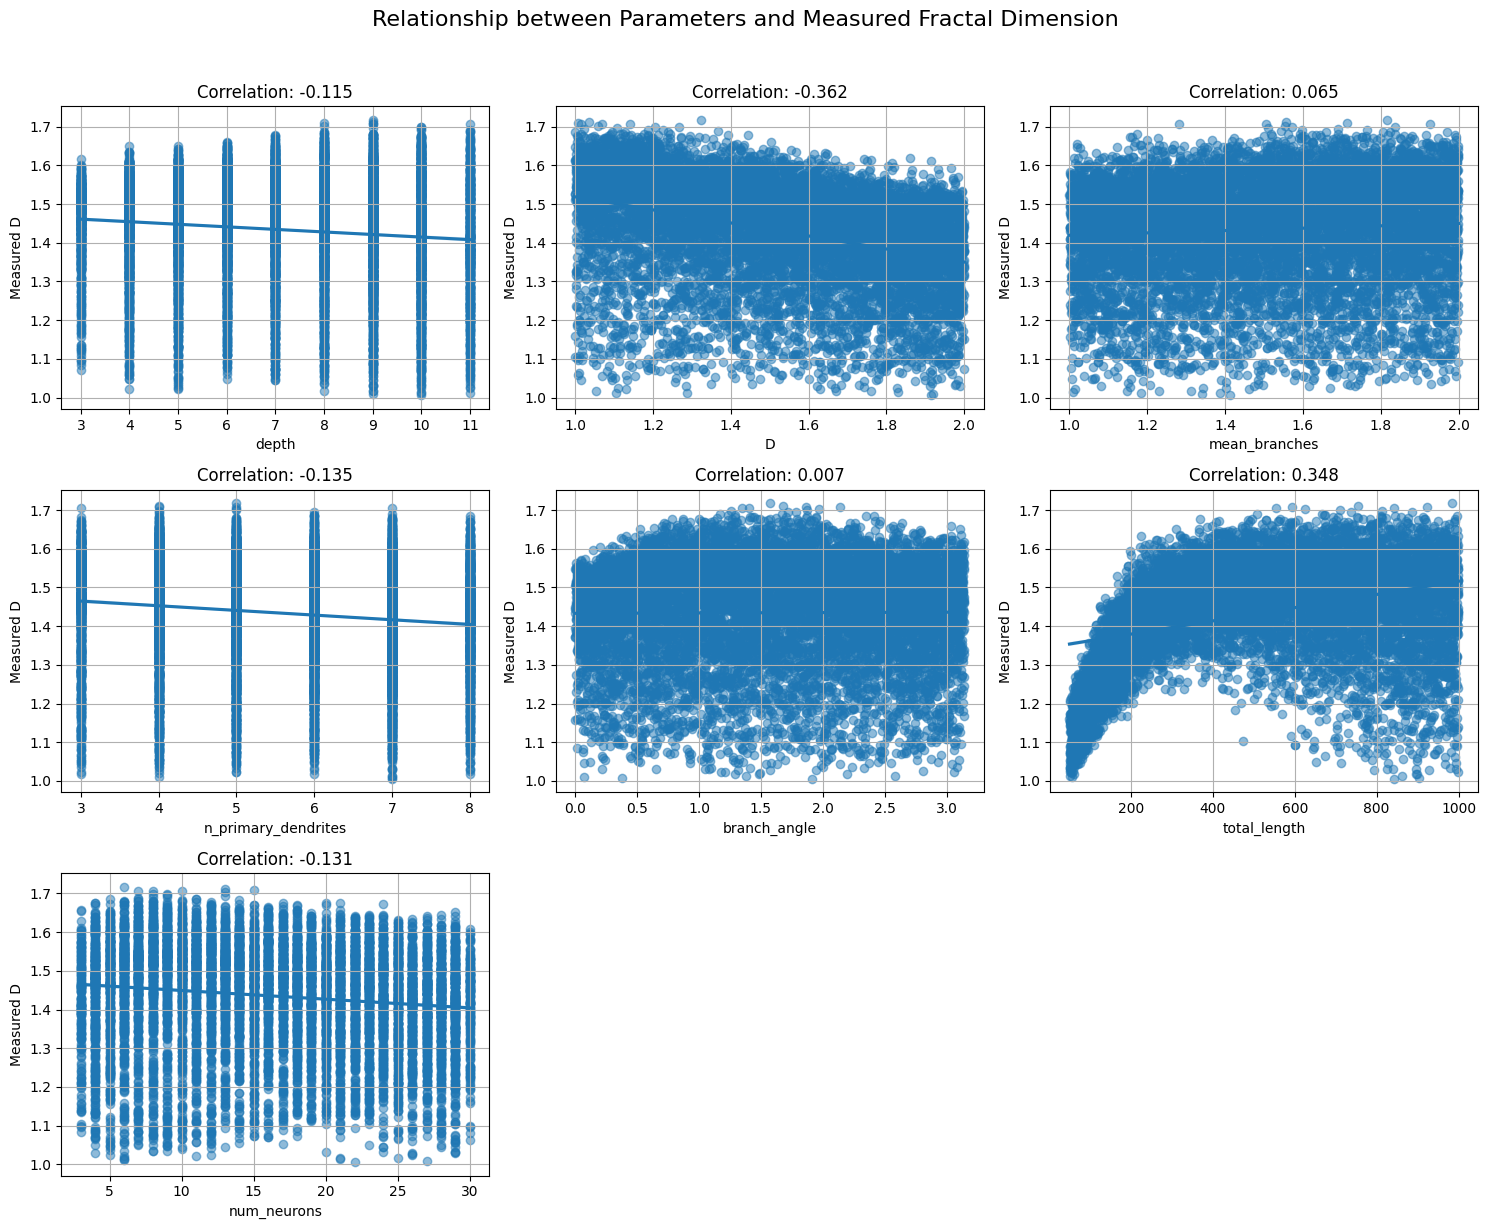


Correlations with d_measured (sorted by magnitude):
d_measured             1.000000
D                     -0.361703
total_length           0.348002
n_primary_dendrites   -0.134721
num_neurons           -0.130514
depth                 -0.115359
mean_branches          0.065426
branch_angle           0.006505
Name: d_measured, dtype: float64


In [3]:
# Read the CSV file
df = pd.read_csv('samples_df_10000.csv')

# Filter out d_measured values outside [1,2]
df_filtered = df[(df['d_measured'] >= 1) & (df['d_measured'] <= 2)]

# Get all columns except d_measured
params = [col for col in df.columns if col != 'd_measured']

# Create subplot grid
n_params = len(params)
n_cols = 3
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle('Relationship between Parameters and Measured Fractal Dimension', fontsize=16, y=1.02)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Create scatter plots
for i, param in enumerate(params):
    ax = axes_flat[i]
    
    # Create scatter plot with trend line
    sns.regplot(data=df_filtered, x=param, y='d_measured', ax=ax, scatter_kws={'alpha':0.5})
    
    ax.set_xlabel(param)
    ax.set_ylabel('Measured D')
    ax.grid(True)
    
    # Calculate correlation coefficient
    corr = df_filtered['d_measured'].corr(df_filtered[param])
    ax.set_title(f'Correlation: {corr:.3f}')

# Remove empty subplots if any
for j in range(i+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

# Print correlations sorted by absolute magnitude
correlations = df_filtered.corr()['d_measured'].sort_values(key=abs, ascending=False)
print("\nCorrelations with d_measured (sorted by magnitude):")
print(correlations)

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import zscore

def find_parameter_tracks(df, d_target, d_tolerance=0.05, n_tracks=3, min_samples=10):
    """
    Find different parameter combinations that lead to similar D values.
    
    Parameters:
    -----------
    df : DataFrame
        The dataset containing parameters and d_measured
    d_target : float
        The target D value we're looking for
    d_tolerance : float
        How close to d_target we'll accept
    n_tracks : int
        Maximum number of different parameter tracks to find
    min_samples : int
        Minimum number of samples required per track
    
    Returns:
    --------
    DataFrame containing the different parameter tracks
    """
    # Filter for samples close to our target D
    mask = (df['d_measured'] >= d_target - d_tolerance) & \
           (df['d_measured'] <= d_target + d_tolerance)
    df_filtered = df[mask].copy()
    
    # Check if we have enough samples
    if len(df_filtered) < min_samples:
        print(f"Warning: Only found {len(df_filtered)} samples near D={d_target}")
        print(f"Increasing tolerance to find more samples...")
        # Try increasing tolerance until we get enough samples
        while len(df_filtered) < min_samples and d_tolerance < 0.2:
            d_tolerance += 0.02
            mask = (df['d_measured'] >= d_target - d_tolerance) & \
                   (df['d_measured'] <= d_target + d_tolerance)
            df_filtered = df[mask].copy()
    
    print(f"Found {len(df_filtered)} samples within D={d_target}±{d_tolerance}")
    
    if len(df_filtered) < min_samples:
        print("Not enough samples found even with increased tolerance")
        return pd.DataFrame()
    
    # Adjust n_tracks based on available samples
    n_tracks = min(n_tracks, len(df_filtered) // min_samples)
    if n_tracks < 1:
        n_tracks = 1
    
    print(f"Using {n_tracks} tracks")
    
    # Normalize parameters for clustering
    params = [col for col in df.columns if col != 'd_measured']
    df_normalized = pd.DataFrame(
        zscore(df_filtered[params]),
        columns=params
    )
    
    # Find clusters of parameter combinations
    kmeans = KMeans(n_clusters=n_tracks, random_state=42)
    df_filtered['track'] = kmeans.fit_predict(df_normalized)
    
    # Get representative sample from each track
    tracks = []
    for i in range(n_tracks):
        cluster_samples = df_filtered[df_filtered['track'] == i]
        if len(cluster_samples) > 0:
            # Find sample closest to target D value
            closest_idx = (cluster_samples['d_measured'] - d_target).abs().idxmin()
            tracks.append(cluster_samples.loc[closest_idx])
    
    if not tracks:
        print("No valid tracks found")
        return pd.DataFrame()
    
    return pd.DataFrame(tracks)

# Example usage with visualization
target_d_values = [1.2, 1.4, 1.6, 1.8]

for d_target in target_d_values:
    print(f"\nParameter tracks for D ≈ {d_target}:")
    tracks = find_parameter_tracks(df_filtered, d_target)
    
    if not tracks.empty:
        # Print parameters and their ranges for each track
        print("\nParameter values for each track:")
        print(tracks[['d_measured'] + params].round(3))
        
        try:
            # Visualize the parameter differences between tracks
            plt.figure(figsize=(12, 6))
            
            # Plot parallel coordinates
            pd.plotting.parallel_coordinates(
                tracks[['d_measured'] + params], 
                'track',
                colormap=plt.cm.get_cmap("Set2")
            )
            
            plt.xticks(rotation=45)
            plt.title(f'Parameter Tracks for D ≈ {d_target}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create visualization: {e}")
    else:
        print(f"No valid tracks found for D ≈ {d_target}")


Parameter tracks for D ≈ 1.2:
Found 708 samples within D=1.2±0.05
Using 3 tracks

Parameter values for each track:
      d_measured  depth      D  mean_branches  n_primary_dendrites  \
4938         1.2    9.0  1.826          1.052                  6.0   
7298         1.2   11.0  1.768          1.195                  5.0   
4728         1.2    8.0  1.725          1.648                  8.0   

      branch_angle  total_length  num_neurons  
4938         1.880       870.983         21.0  
7298         0.495        95.778          6.0  
4728         2.862        55.892         26.0  
Could not create visualization: 'track'

Parameter tracks for D ≈ 1.4:
Found 2229 samples within D=1.4±0.05
Using 3 tracks

Parameter values for each track:
      d_measured  depth      D  mean_branches  n_primary_dendrites  \
5464         1.4    5.0  1.525          1.676                  7.0   
2499         1.4    6.0  1.041          1.370                  7.0   
4596         1.4    7.0  1.868          1.30

/tmp/ipykernel_1020868/1273900011.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=plt.cm.get_cmap("Set2")
/tmp/ipykernel_1020868/1273900011.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=plt.cm.get_cmap("Set2")
/tmp/ipykernel_1020868/1273900011.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=plt.cm.get_cmap("Set2")
/tmp/ipykernel_1020868/1273900011.py:102: MatplotlibDeprecationWarning: The get_cmap function was depre

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Found 1807 samples within D=1.6±0.05
Using 3 tracks


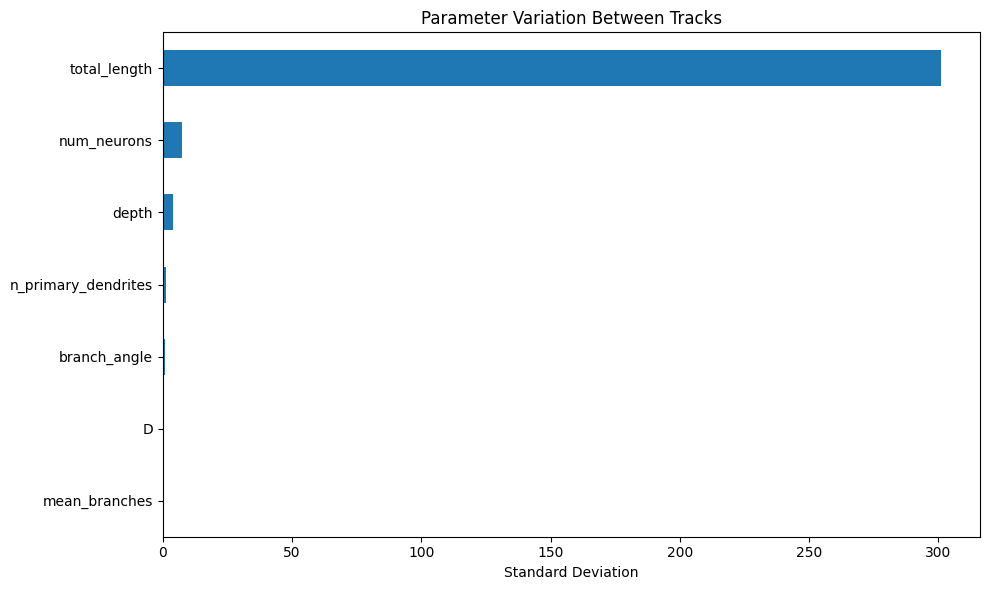


Key parameter trade-offs:
depth: varies from 4.00 to 11.00
total_length: varies from 391.14 to 974.13
num_neurons: varies from 11.00 to 25.00


In [8]:
def analyze_track_differences(tracks):
    """
    Analyze how parameters differ between tracks
    """
    # Calculate parameter ranges within each track
    param_ranges = tracks[params].agg(['min', 'max', 'std'])
    
    # Calculate parameter importance in distinguishing tracks
    param_variations = tracks[params].std()
    
    return param_ranges, param_variations

# Add visualization of parameter importance
def plot_parameter_importance(tracks):
    """
    Visualize which parameters vary most between tracks
    """
    param_std = tracks[params].std()
    
    plt.figure(figsize=(10, 6))
    param_std.sort_values().plot(kind='barh')
    plt.title('Parameter Variation Between Tracks')
    plt.xlabel('Standard Deviation')
    plt.tight_layout()
    plt.show()

# Example usage for a specific D value:
d_target = 1.6
tracks = find_parameter_tracks(df_filtered, d_target)
param_ranges, param_variations = analyze_track_differences(tracks)
plot_parameter_importance(tracks)

# Print insights
print("\nKey parameter trade-offs:")
for param in params:
    if param_variations[param] > param_variations.median():
        print(f"{param}: varies from {param_ranges.loc['min', param]:.2f} to {param_ranges.loc['max', param]:.2f}")